In [2]:
import os
import re
import keras
import urllib
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from collections import OrderedDict, Counter

from keras import metrics
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3

from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
sns.set_style('white')
plt.style.use('bmh')

## Downloading images, converting them to numpy arrays

In [118]:
df = pd.read_json('data/themoviedb-sample-4-17-2017.json')
df = df[df['poster_path'].isnull() == False]
df['poster_url'] = df['poster_path'].apply(lambda x: 'http://image.tmdb.org/t/p/w92{}'.format(x))
df = df[['title', 'genre', 'poster_url']]
print(df.shape)
df.head()

(9175, 3)


,title,genre,poster_url
0,Bought,Documentary,http://image.tmdb.org/t/p/w92/5q3CQLHMbvsjxK4V...
1,Egypt Underworld,Documentary,http://image.tmdb.org/t/p/w92/vHZf7KA7RGMxWl2r...
2,Chinese Heroes,Action,http://image.tmdb.org/t/p/w92/74F1NxjpQFoXoJzG...
3,Shakedown,Action,http://image.tmdb.org/t/p/w92/eILw7xfKn99cPU6n...
4,Shakedown,Drama,http://image.tmdb.org/t/p/w92/eILw7xfKn99cPU6n...


#### Downloading all the posters
Here, we download them at the smallest size (width = 92 pixels). 

In [120]:
for url in df['poster_url'].unique():
    file_name = re.findall(r'(?<=w92\/)(.*)', url)[0]
    if file_name not in os.listdir('data/img'):
        urllib.urlretrieve(url, 'data/img/{}'.format(file_name))

#### Flattening into numpy arrays
Resizing images to `(138, 92, 3)`. We expect this will lose us some precision later.

In [98]:
images = []
y = []

for image_file in os.listdir('data/img'):
    img = load_img('data/img/{}'.format(image_file))
    images.append(np.resize(img_to_array(img),(138,92,3)))
    y.append(np.array([x for x in df[df['poster_url'] == 'http://image.tmdb.org/t/p/w92/{}'.format(image_file)]['genre'].values]))

## $y$: Multi-label

In [121]:
y[0:5]

[array([u'Drama', u'Comedy', u'Crime'], 
       dtype='<U6'), array([u'Action', u'Adventure'], 
       dtype='<U9'), array([u'Drama', u'Comedy'], 
       dtype='<U6'), array([u'Documentary', u'Music'], 
       dtype='<U11'), array([u'Adventure', u'Western'], 
       dtype='<U9')]

In [122]:
X = np.array(images)
# Normalizing away from 255
X = X / 255.
input_shape = X.shape
print(input_shape)

(4722, 138, 92, 3)


In [8]:
all_genres = pd.DataFrame(index = range(0,4722))

for row in y:
    for genre in row:
        if genre in all_genres:
            pass
        else:
            all_genres[genre] = 0

for index, row in enumerate(y):
    for genre in row:
        all_genres[genre].loc[index] = 1
        
print(all_genres.shape)
all_genres.head()

(4722, 20)


,Drama,Comedy,Crime,Action,Adventure,Documentary,Music,Western,Horror,Animation,Family,Thriller,Mystery,Science Fiction,History,TV Movie,Romance,Foreign,War,Fantasy
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
Y = np.array(all_genres)
print(Y.shape)

(4722, 20)


#### Fitting a simple CNN model

In [51]:
# Super simple CNN
model = Sequential()

# Input layer
model.add(Conv2D(80, activation='relu', 
                 kernel_size=(2, 2),
                 data_format = 'channels_last',
                 input_shape=(138,92,3)))

# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))

# --- next layer ---
# we could double the number of filters as max pool made the 
# feature maps much smaller 
# just not doing this to improve runtime
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))

# --- next layer ---
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))
# # --- regularize our model in order to prevent overfitting
model.add(Dropout(0.25))

# # --- next layer ---
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# # --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))
# # --- regularize our model in order to prevent overfitting
model.add(Dropout(0.25))

# flatten for fully connected classification layer
model.add(Flatten())
# --- fully connected layer ---
model.add(Dense(32, activation='relu'))
# # --- regularize our model in order to prevent overfitting
model.add(Dropout(0.5))
# --- Last layer: classification ---
model.add(Dense(20, activation='sigmoid'))

# prints out a summary of the model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 137, 91, 80)       1040      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 68, 45, 80)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 66, 43, 16)        11536     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 33, 21, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 31, 19, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 9, 32)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 9, 32)         0         
__________

In [52]:
sgd = SGD(lr=0.001, momentum=0.9)
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['mae', 'categorical_accuracy'])

In [53]:
batch_size = 12
early_stopping_monitor = EarlyStopping(patience = 3)

# Fit model on training data
history = model.fit(X, Y,
                    validation_split = 0.2,
                    batch_size=batch_size,
                    epochs = 10,
                    callbacks = [early_stopping_monitor],
                    verbose=1)


Train on 3777 samples, validate on 945 samples
Epoch 1/10
3777/3777 [==============================] - 202s - loss: 0.5552 - mean_absolute_error: 0.3877 - categorical_accuracy: 0.0522 - val_loss: 0.3723 - val_mean_absolute_error: 0.2755 - val_categorical_accuracy: 0.1820
Epoch 2/10
3777/3777 [==============================] - 175s - loss: 0.3968 - mean_absolute_error: 0.2484 - categorical_accuracy: 0.1202 - val_loss: 0.3190 - val_mean_absolute_error: 0.2260 - val_categorical_accuracy: 0.3693
Epoch 3/10
3777/3777 [==============================] - 183s - loss: 0.3602 - mean_absolute_error: 0.2207 - categorical_accuracy: 0.2002 - val_loss: 0.3000 - val_mean_absolute_error: 0.2014 - val_categorical_accuracy: 0.3693
Epoch 4/10
3777/3777 [==============================] - 205s - loss: 0.3486 - mean_absolute_error: 0.2109 - categorical_accuracy: 0.2367 - val_loss: 0.2958 - val_mean_absolute_error: 0.1966 - val_categorical_accuracy: 0.3693
Epoch 5/10
3777/3777 [==============================]

In [134]:
model.save_weights('model_weight.h5')

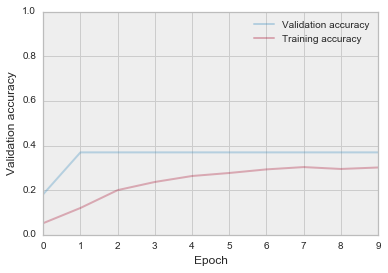

In [54]:
plt.plot(history.history['val_categorical_accuracy'], alpha = 0.3, label = 'Validation accuracy')
plt.plot(history.history['categorical_accuracy'], alpha =  0.3, label = 'Training accuracy')
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.ylim([0,1])
plt.legend(loc = 'best')
plt.show()

In [55]:
# Predicted lables per movie
preds = model.predict(X)
Y[0], preds[0]

(array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 0.37765497,  0.2958824 ,  0.11450594,  0.19459571,  0.0949719 ,
         0.23955071,  0.09856158,  0.03283762,  0.18335375,  0.08520014,
         0.10814912,  0.22505662,  0.05513801,  0.104148  ,  0.03615821,
         0.05231433,  0.15095164,  0.04352754,  0.0287931 ,  0.06801955], dtype=float32))

### Precision and recall

In [75]:
# Precision and Recall
# --Precision: number of true positives over the number of true positives plus the number of false positives
# --Recall: number of true positives over the number of true positives plus the number of false negatives
precision = dict()
average_precision = dict()
recall_score = dict()
recall = dict()
for i in range(20):
    precision[i], recall[i], _ = precision_recall_curve(Y[:, i],
                                                        preds[:, i])
    #average_precision[i] = average_precision_score(Y[:, i], preds[:, i])
    recall_score[i] = recall[i].mean()
    average_precision[i] = precision[i].mean()

names = ['id','data']
formats = ['f8','f8']
dtype = dict(names = names, formats=formats)
average_precision_np = pd.DataFrame(np.array(average_precision.items(), dtype=dtype))
average_precision_np['genre'] = list(all_genres.columns.values)

recall_score_np = pd.DataFrame(np.array(recall_score.items(), dtype=dtype))
recall_score_np['genre'] = list(all_genres.columns.values)

In [79]:
# Sort genres by precision and recall
average_precision_np = average_precision_np.sort_values(by = 'data', ascending=[0])
recall_score_np = recall_score_np.sort_values(by = 'data', ascending=[0])

# Average precision and recall across labels
mean_precision = average_precision_np.data.median()
mean_recall = recall_score_np.data.mean()

# F1 score
F1 = 2*(mean_precision*mean_recall)/(mean_precision+mean_recall)

# Print results
print ("# Overall precision and recall #")
print ('Mean Precision:'), round(mean_precision, 4)
print ('Mean Recall:'), round(mean_recall, 4)
print ('F1 Score:'), round(F1, 4)

# Overall precision and recall #
Mean Precision: 0.0641
Mean Recall: 0.4899
F1 Score: 0.1133


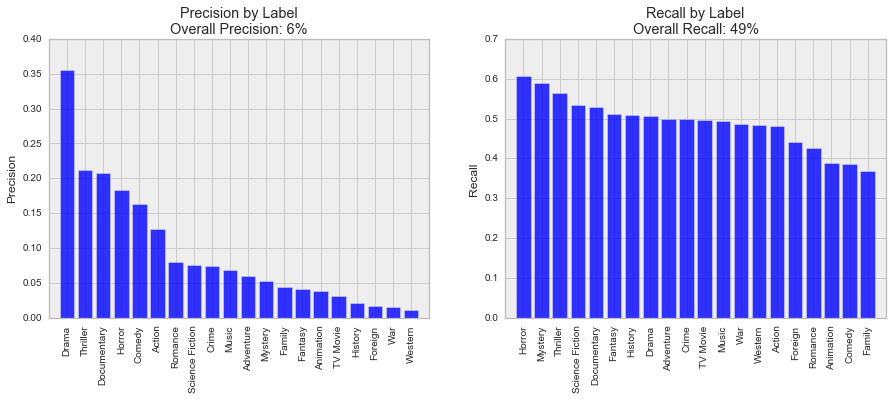

In [80]:
# Precision and recall by label
y_pos = np.arange(len(average_precision_np.genre)) + 1

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)

ax1 = plt.bar(y_pos, average_precision_np.data, align='center', alpha=0.8, color='b')
ax1 = plt.xticks(y_pos, average_precision_np.genre, rotation=90)
ax1 = plt.xlim([0,21])
ax1 = plt.ylabel('Precision')
ax1 = plt.title('Precision by Label\nOverall Precision: {:.0f}%'.format(mean_precision*100))

ax2 = fig.add_subplot(1, 2, 2)

ax2 = plt.bar(y_pos, recall_score_np.data, align='center', alpha=0.8, color='b')
ax2 = plt.xticks(y_pos, recall_score_np.genre, rotation=90)
ax2 = plt.xlim([0,21])
ax2 = plt.ylabel('Recall')
ax2 = plt.title('Recall by Label\nOverall Recall: {:.0f}%'.format(mean_recall*100))

plt.show()

## Pre-trained model

### Attempt 1

### Attempt 2